

>Dataset download



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 158M/158M [00:01<00:00, 99.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


Global variables

In [29]:
IMG_size = 224
BATCH_size = 32
EPOCHS = 10
LR = 0.05

**Možná přidat set_seed funkci, abychom měli stále stejné výsledky**

Import libraries

In [4]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 52.3 MB/s eta 0:00:00


In [5]:
# for data preprocessing
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# for model creation
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchmetrics.classification import Accuracy

Dataset augmentation (applying random rotations, etc. to diverify data)

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_size, IMG_size), antialias=True),  # Resize images to 224x224 pixels, antialias smoothens the picture after resizing
    #transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    #transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    #transforms.ColorJitter(brightness=1, contrast=3),  # Adjust brightness and contrast
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# je dobré obrázek jen vyrotovat nebo ho vyrotovat a vytvořit z něj několik obrázků, které pak použiji do trénovacího datasetu

Dataset loading

In [7]:
test_path = path + "/Covid19-dataset/test"
train_path = path + "/Covid19-dataset/train"
data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

train_loader = DataLoader(data_train,batch_size=BATCH_size, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_size, drop_last=True)

In [8]:
len(data_test), len(data_train)

(66, 251)

In [9]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


**Not needed - just to illustrate: function that shows one image from each category**

Class names: ['Covid', 'Normal', 'Viral Pneumonia']


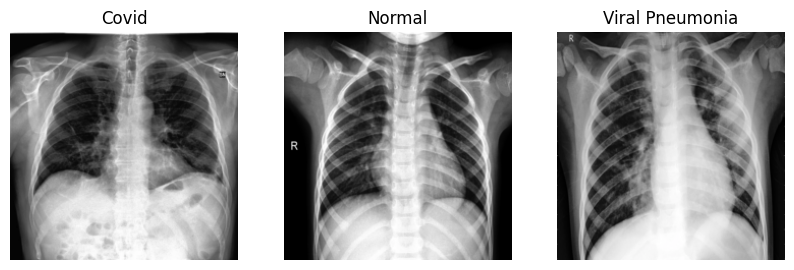

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)
# Define mean and std for denormalizing (same as used in normalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize the image
def denormalize(img, mean, std):
    img = img.clone()  # Clone the tensor to avoid modifying the original
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    img = denormalize(img, mean, std)  # Denormalize the image
    img = img.clamp(0, 1)  # Ensure values are in the range [0, 1] for display
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Class names: ['Covid', 'Normal', 'Viral Pneumonia']


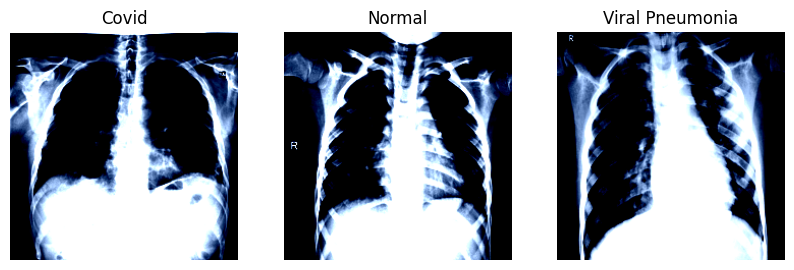

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    # If we don't have an image for this class label, add it to the dictionary
    if label not in images_per_class:
        images_per_class[label] = img
    # Stop if we have one image per class
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from Tensor shape [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Define model

In [40]:
class CovidXrayClassifier(pl.LightningModule):

    # Define initialization function
    def __init__(self, num_classes=3, lr=LR):
        super(CovidXrayClassifier, self).__init__()

        # Load pretrained model
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        # Define learning rate, batch size and number of classes
        self.lr = lr
        self.batch_size = BATCH_size
        self.num_classes = num_classes

        # Define Loss function and accuraccy metric
        self.criterion = nn.CrossEntropyLoss()      # for now crossentropy, maybe change later
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        # Train and test accuracy
        self.train_losses, self.train_accs, self.val_losses, self.val_accs = [], [], [], []
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # Define forward step
    def forward(self, x):
        return self.model(x)

    # Define a single step during training
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)

    # Define a single step during training
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_accuracy(outputs, labels)

        # Log validation metric
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', self.accuracy(outputs, labels), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        # Store metrics for plotting after each epoch
        self.train_losses.append(self.trainer.callback_metrics["val_loss_epoch"].item())
        self.train_accs.append(self.trainer.callback_metrics["val_acc_epoch"].item())

    def on_validation_epoch_end(self):
        # Store metrics for plotting after each epoch
        self.val_losses.append(self.trainer.callback_metrics["val_loss_epoch"].item())
        self.val_accs.append(self.trainer.callback_metrics["val_acc_epoch"].item())

    # Define optimizer for training
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)   #maybe choose different optimizer
        return optimizer


Train model

In [41]:
# Initialize model
model = CovidXrayClassifier()

#lr_monitor = LearningRateMonitor(logging_interval='epoch')
#early_stop_callback = EarlyStopping(monitor='val_loss',  patience=2, verbose=True, mode='min')
#checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='savefile' )

# Initialize trainer
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator= 'gpu', log_every_n_steps=1)


# train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | accuracy       | MulticlassAccuracy | 0      | train
3 | train_accuracy | MulticlassAccuracy | 0      | train
4 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
72        Modules in train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Results

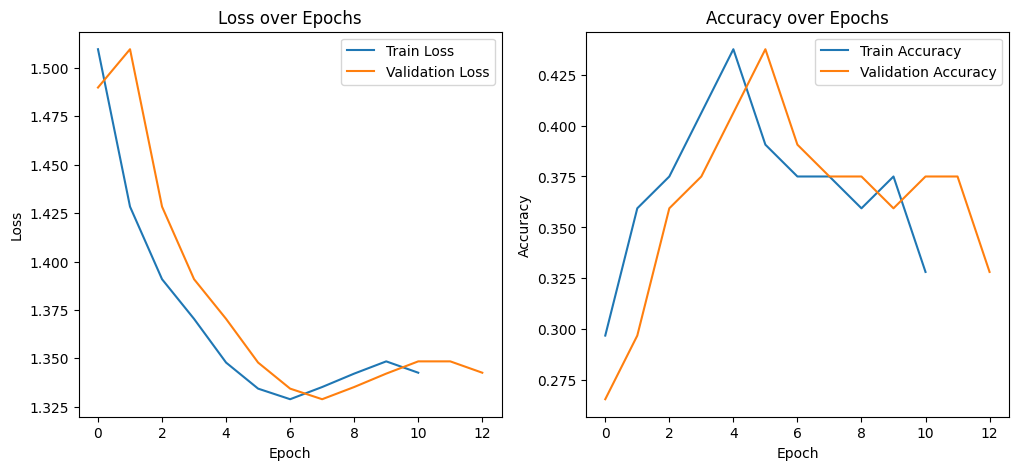

In [45]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(model.train_accs, label="Train Accuracy")
plt.plot(model.val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

Define average loss function

Cross-Entropy Loss: Best for general multi-class classification tasks where class distribution is relatively balanced.
Focal Loss: Useful for imbalanced datasets or when you want to pay more attention to harder examples.
KL Divergence Loss: Good when working with soft labels or probabilistic predictions.
Label Smoothing Cross-Entropy: Helps to improve generalization and avoid overfitting by preventing the model from being too confident.